In [1]:
%load_ext autoreload
%autoreload 2

curr_dir = '/user_data/vayzenbe/GitHub_Repos/goodale-milner-dnns'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys


sys.path.append('DeepDive')
sys.path.append('CORnet')
from deepdive.feature_extraction import get_empty_feature_maps, StimulusSet, get_all_feature_maps



import cornet

import torch

import torch.nn as nn
import torchvision
from torchvision.models import resnet18, alexnet, vgg19, vgg11


from sklearn.model_selection import StratifiedShuffleSplit

from sklearn import svm

import warnings

from tqdm import tqdm
import itertools
warnings.filterwarnings('ignore')
import pdb
from glob import glob as glob
from PIL import Image
import natsort
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

/home/vayzenbe/anaconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_suf = ''

splits = 20


transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize(224),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                 std=[0.5, 0.5, 0.5]),
#                 torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225])
            ])

models = ['alexnet','vgg19','resnet18','cornet_z','cornet_s']

In [3]:
def load_model(model_arch):   
    if model_arch =='cornet_z':
        model = cornet.get_model('z', pretrained=True, map_location=torch.device('cpu')).module

    elif model_arch =='cornet_s':
        model = cornet.get_model('s', pretrained=True, map_location=torch.device('cpu')).module

    elif model_arch =='alexnet':
        model = alexnet(pretrained=True)

    elif model_arch =='vgg19':
        model = vgg19(pretrained=True)

    elif model_arch =='resnet18':
        model = resnet18(pretrained=True)
        
    return model

In [4]:
def get_loader(stim_dir):
    test_dataset =torchvision.datasets.ImageFolder(stim_dir, transform=transform)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers = 2, pin_memory=True)
    return testloader, test_dataset


In [5]:
def plot_all_models(model_df,exp_name,file_suf=''):

    model_df['model layer'] = [f'{model}        {layer}' for model, layer in zip(model_df['model'], model_df['layer'])]
    fig = plt.figure(figsize=(25,5))
    ax = sns.barplot(data = model_df, x='model layer', hue='model', y='accuracy',dodge=False )
    ax.axhline(y=0.5, color='r', linestyle='--')
    plt.ylim(0, 1.1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    #set yaxis interval to .25
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.25))
    plt.legend().remove()
    #increase font size of y axis labels
    plt.setp(ax.get_yticklabels(), fontsize=14)
    
    #change y axis title to accuracy
    ax.set_ylabel('Accuracy', fontsize=16)

    plt.title(exp_name, fontsize = 16)
    
    #     plt.tight_layout()
    plt.savefig(f'figures/models_{exp_name}_acc{file_suf}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [14]:
from sklearn.linear_model import LogisticRegression
def get_label_match_mat(labels):
    label_mat = np.zeros((len(labels), len(labels)), dtype=bool)
    for ii, label1 in enumerate(labels):
        for jj, label2 in enumerate(labels):
            label_mat[ii,jj] = label1 == label2
    return label_mat

def prep_similarities(X, y):
    sims = np.corrcoef(X)
    trili = np.tril_indices(sims.shape[0], k=-1)
    label_mat = get_label_match_mat(y)
    samediff = label_mat[trili]
    return sims[trili], samediff, sims

def paired_similarity_discrimination(acts, labels):
    acc = []
    sames = []
    diffs = []
    for label_pair in itertools.combinations(np.unique(labels), 2):
        sss = StratifiedShuffleSplit(n_splits=splits, test_size=.333)
        #run classifier
    #         these_accs = []
        inds = np.argwhere([label in label_pair for label in labels])
        #convert inds to list
        inds = inds.squeeze().tolist()
            
        acts_ = acts[inds]
        labels_ = labels[inds]

        sims_vec, samediff, sims = prep_similarities(acts_, labels_)

        for i, (train_index, test_index) in enumerate(sss.split(sims_vec, samediff)):
            test_corrs = sims_vec[test_index]
            test_labels = samediff[test_index]
           
        
            same_corr = np.mean(test_corrs[test_labels == True])
            diff_corr = np.mean(test_corrs[test_labels == False])

            if same_corr > diff_corr:
                acc.append(1)
            elif same_corr == diff_corr:
                acc.append(.5)
            else:
                acc.append(0)
           

    return acc
        

In [15]:
def plot_rdm(data,image_paths, condition, experiment, model_arch, layer, file_suf=''):
    # Load images and set tick labels
    images = []
    ticklabels = []
    for path in image_paths:
        im = Image.open(path).convert('RGB')
        #convert to numpy array
        img = np.array(im)

        
        images.append(img)


    # Create the heatmap with Seaborn
    ax = sns.heatmap(data)

    xtick_labels = ax.get_xticklabels()
    ytick_labels = ax.get_yticklabels()

    for i, im in enumerate(images):

        ib = OffsetImage(im, zoom=.025)
        ib.image.axes = ax
        ab = AnnotationBbox(ib,
                            xtick_labels[i].get_position(),
                            frameon=False,
                            box_alignment=(.5, -.2)
                            )
        ax.add_artist(ab)


        ab = AnnotationBbox(ib,
                                ytick_labels[i].get_position(),
                                frameon=False,
                                box_alignment=(1.2,.5)
                                )

        ax.add_artist(ab)

    plt.xticks([]) 
    plt.yticks([])
    #tight layout
    plt.tight_layout()
        
        

    plt.savefig(f'figures/rdms/{condition}_{experiment}_{model_arch}_{layer}_acc{file_suf}.png', dpi=300, bbox_inches='tight')
    plt.close()

100%|██████████| 5/5 [02:33<00:00, 30.65s/it]


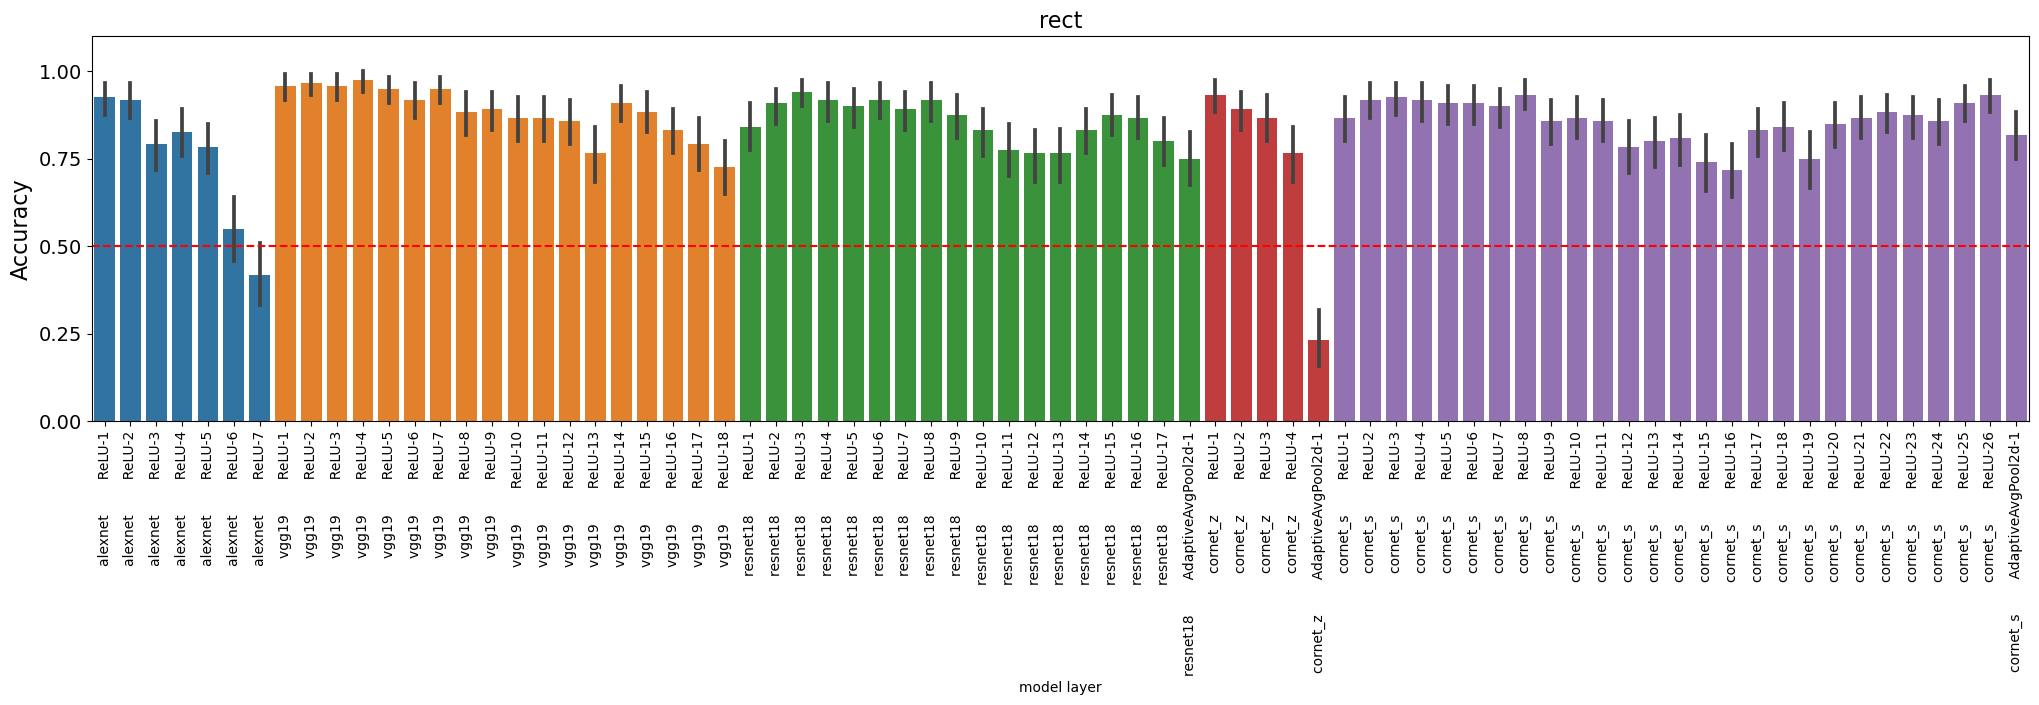

100%|██████████| 5/5 [02:26<00:00, 29.39s/it]


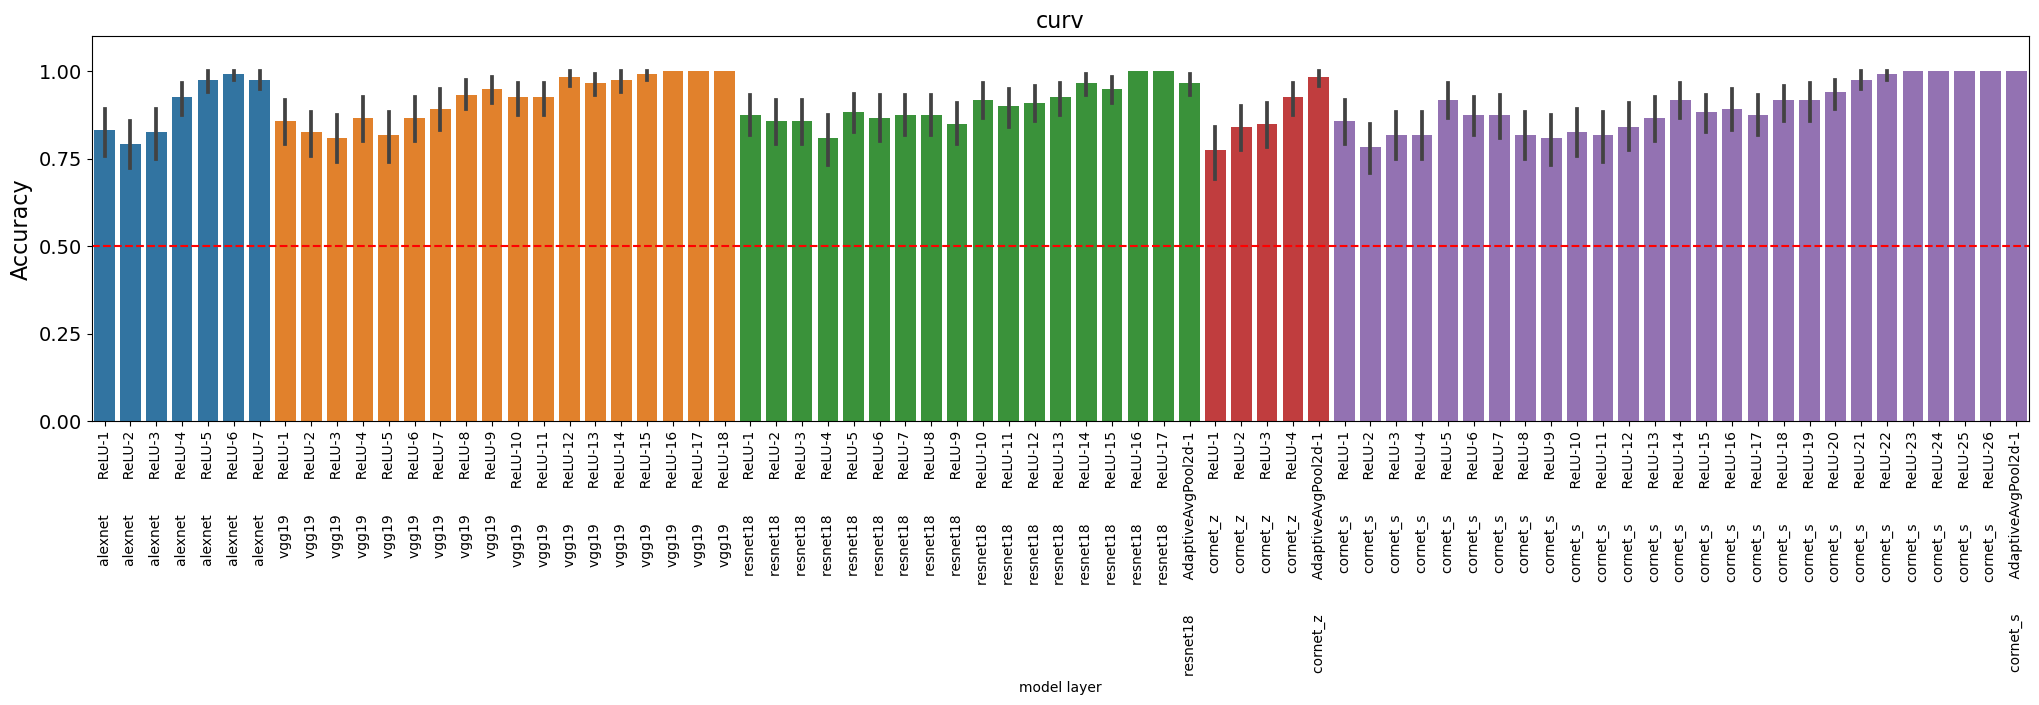

In [16]:
# get correlation distnace between same/different

condition = 'rot'
for experiment, exp_name in zip(['rect', 'curv'], ['Rectilinear', 'Curvilinear']):
    
    testloader, test_dataset = get_loader(f'{curr_dir}/stim/{experiment}_{condition}')
    image_paths = natsort.natsorted(glob(f'{curr_dir}/stim/{experiment}_{condition}/*/*.jpg'))

    labels = torch.cat([labels for inputs, labels in testloader]).numpy()
    cat_num = len(test_dataset.classes)

    model_df = dict(model=[], layer=[], accuracy=[], experiment=[])
    for model_arch in tqdm(models):
        model = load_model(model_arch)
        model_layers = get_empty_feature_maps(model, testloader, names_only = True)
        # in general let's just use the ReLU layers, but also the average pooling over space that occurs in ResNet and CORnet models without rectifcation before the classifier
        layers = [layer for layer in model_layers if 'ReLU' in layer or 'AdaptiveAvgPool2d-1' in layer]
        model.to('cuda')
        activations = get_all_feature_maps(model, testloader, layers_to_retain=layers)

        for layer in layers:
            sims = np.corrcoef(activations[layer])
            plot_rdm(sims, image_paths, condition, experiment, model_arch, layer)
            
            accs = paired_similarity_discrimination(activations[layer], labels)
            
            for acc in accs:
                model_df['model'].append(model_arch)
                model_df['layer'].append(layer)
                model_df['accuracy'].append(acc)
                model_df['experiment'].append(experiment)
        
    model_df = pd.DataFrame(model_df)
    model_df.to_csv(f'{curr_dir}/results/{exp_name}_acc_{condition}_similarity.csv')
    

    plot_all_models(model_df,experiment,file_suf=f'_{condition}_similarity')

    

100%|██████████| 5/5 [02:27<00:00, 29.43s/it]


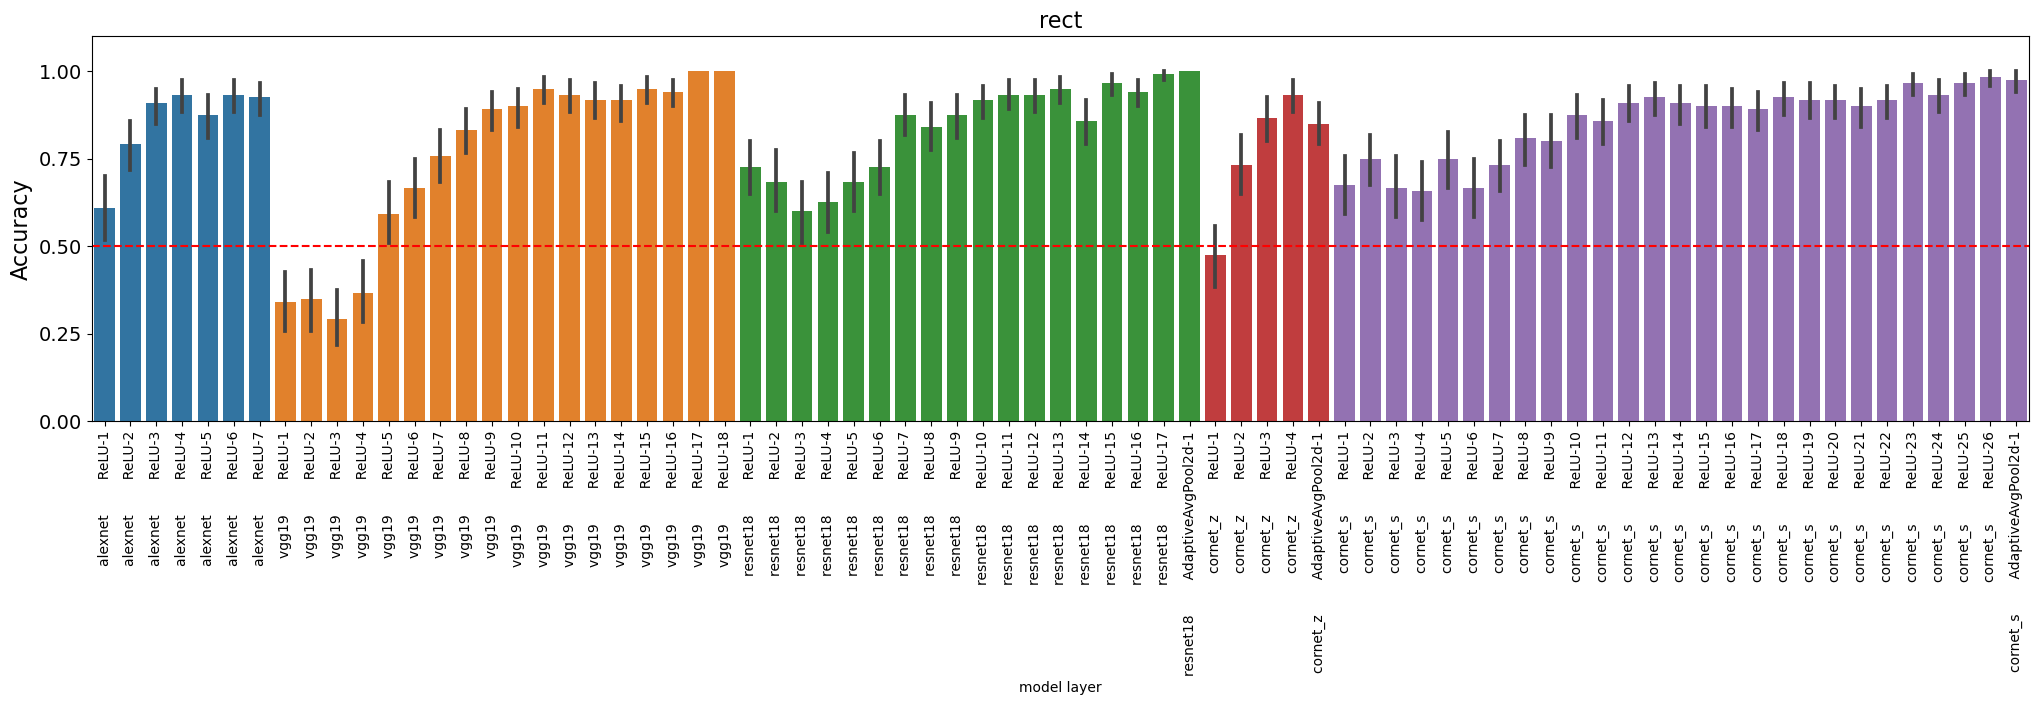

 20%|██        | 1/5 [00:52<03:28, 52.16s/it]


KeyboardInterrupt: 

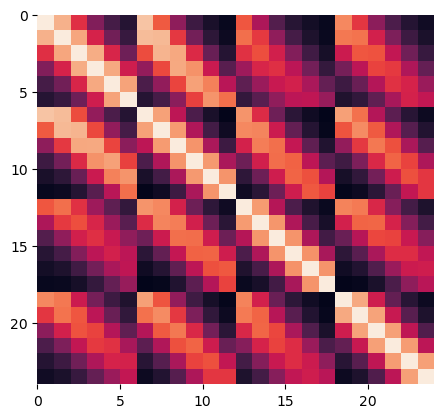

In [17]:
# get correlation distnace between same/different

condition = 'scale'
for experiment, exp_name in zip(['rect', 'curv'], ['Rectilinear', 'Curvilinear']):
    
    testloader, test_dataset = get_loader(f'{curr_dir}/stim/{experiment}_{condition}')
    image_paths = natsort.natsorted(glob(f'{curr_dir}/stim/{experiment}_{condition}/*/*.jpg'))

    labels = torch.cat([labels for inputs, labels in testloader]).numpy()
    cat_num = len(test_dataset.classes)

    model_df = dict(model=[], layer=[], accuracy=[], experiment=[])
    for model_arch in tqdm(models):
        model = load_model(model_arch)
        model_layers = get_empty_feature_maps(model, testloader, names_only = True)
        # in general let's just use the ReLU layers, but also the average pooling over space that occurs in ResNet and CORnet models without rectifcation before the classifier
        layers = [layer for layer in model_layers if 'ReLU' in layer or 'AdaptiveAvgPool2d-1' in layer]
        model.to('cuda')
        activations = get_all_feature_maps(model, testloader, layers_to_retain=layers)

        for layer in layers:
            sims = np.corrcoef(activations[layer])
            plot_rdm(sims, image_paths,condition, experiment, model_arch, layer)
            accs = paired_similarity_discrimination(activations[layer], labels)
            for acc in accs:
                model_df['model'].append(model_arch)
                model_df['layer'].append(layer)
                model_df['accuracy'].append(acc)
                model_df['experiment'].append(experiment)
        
    model_df = pd.DataFrame(model_df)
    model_df.to_csv(f'{curr_dir}/results/{exp_name}_acc_{condition}_similarity.csv')
    

    c

    

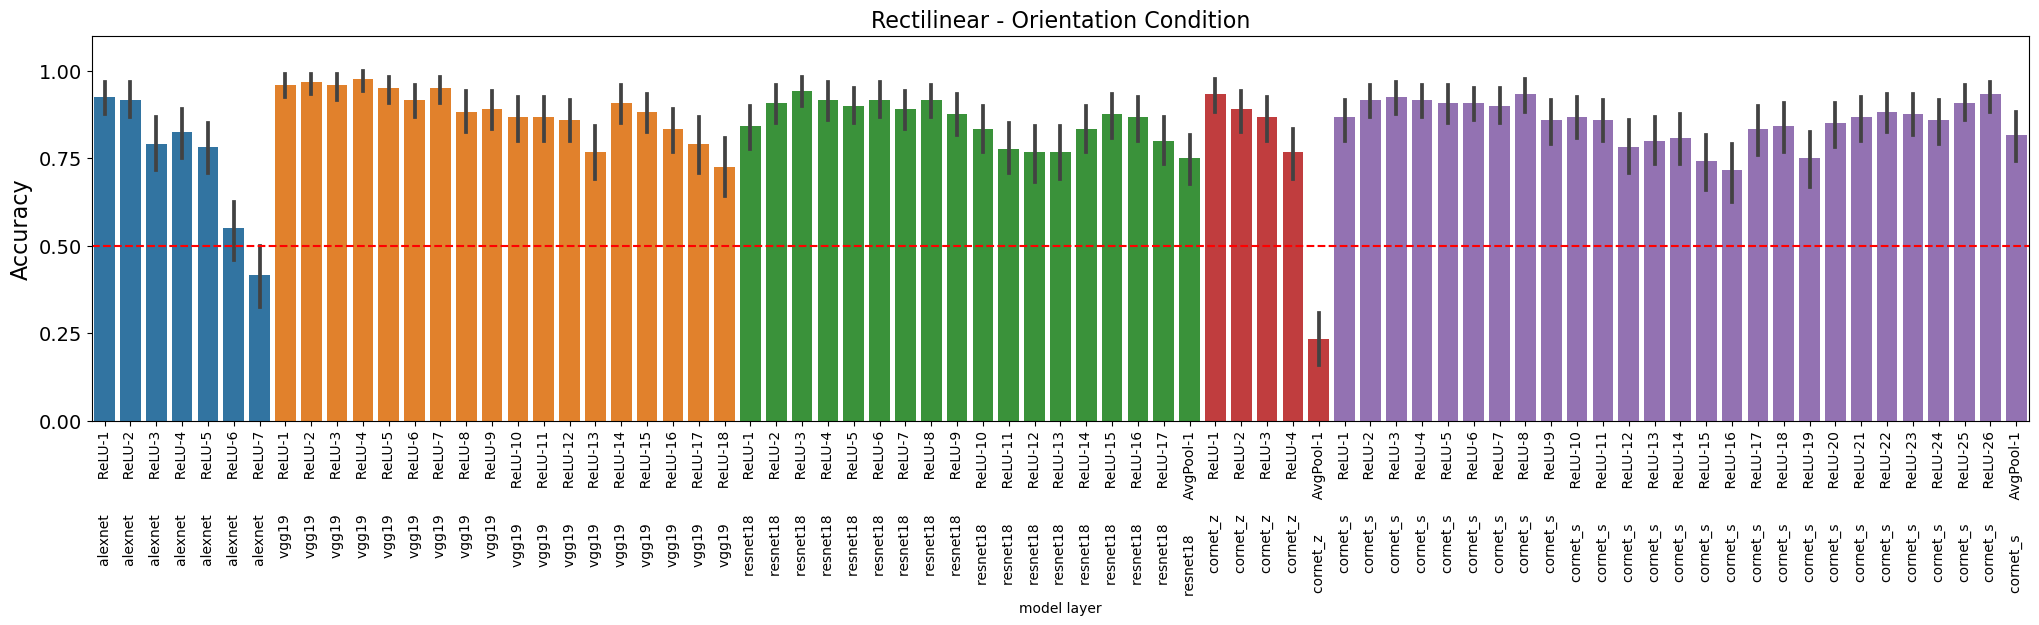

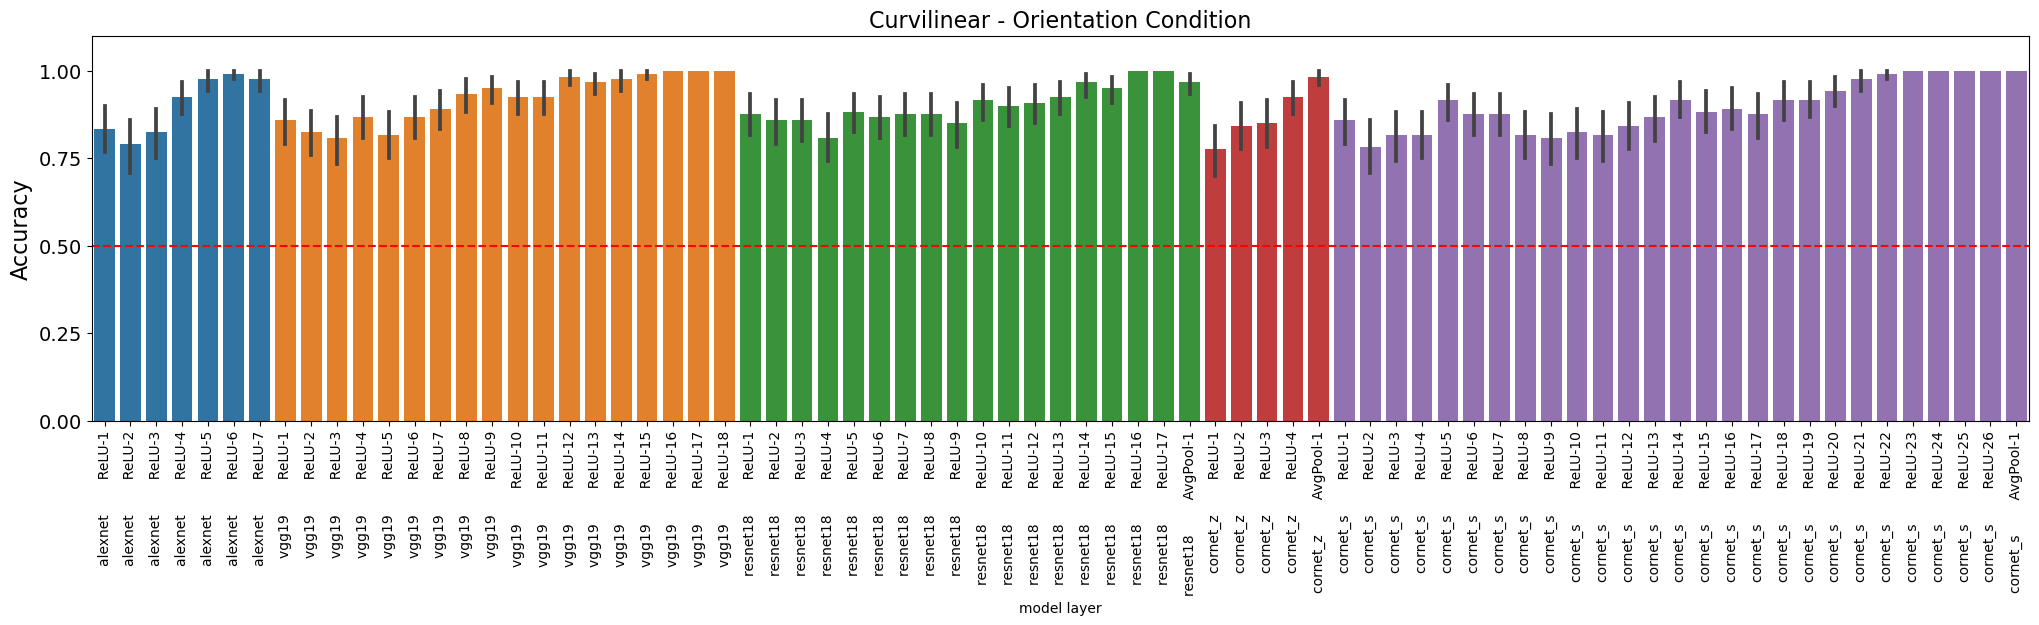

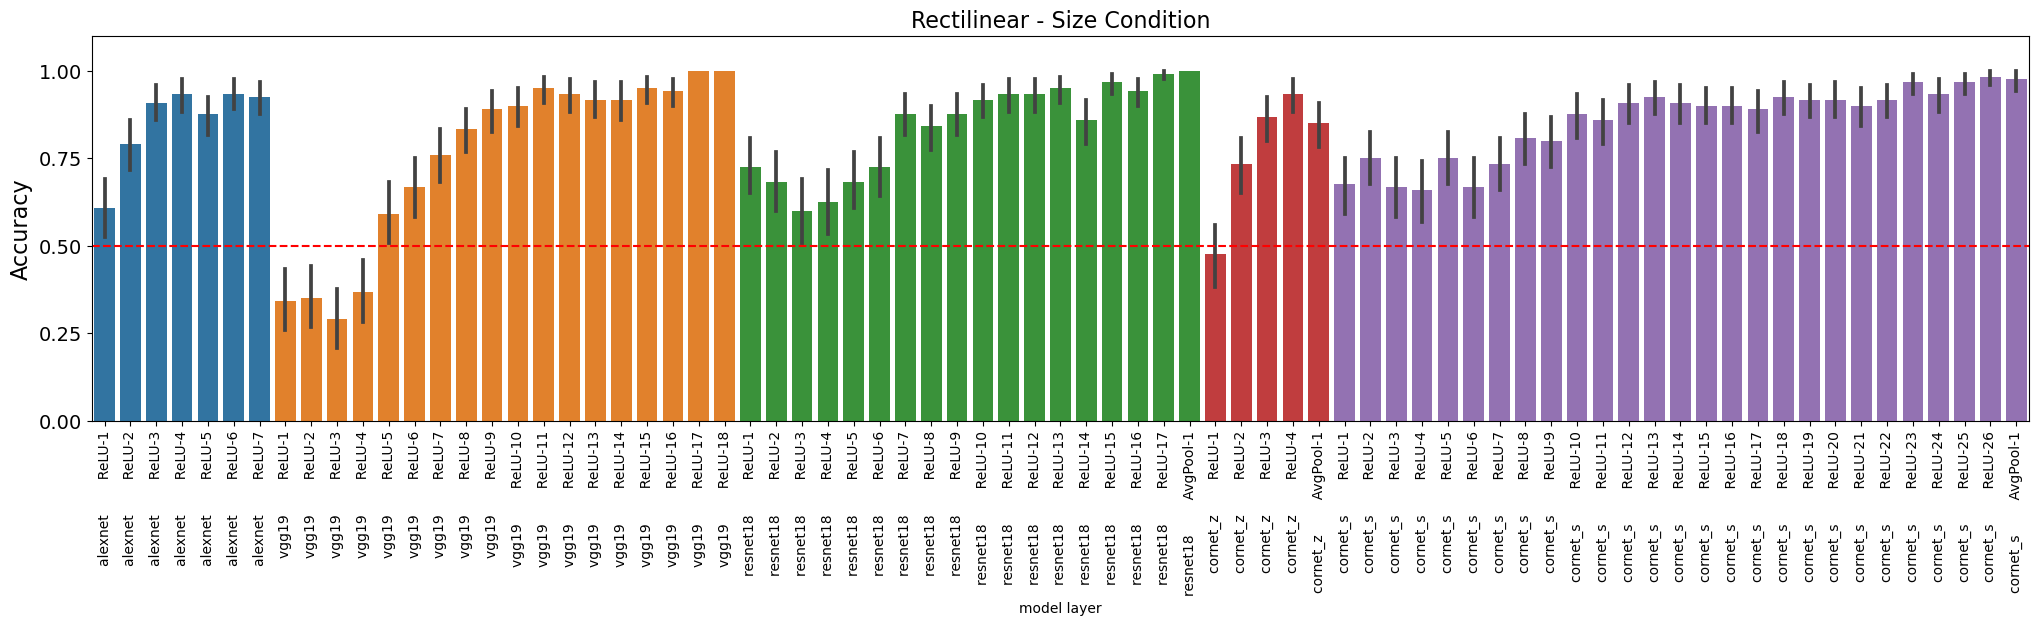

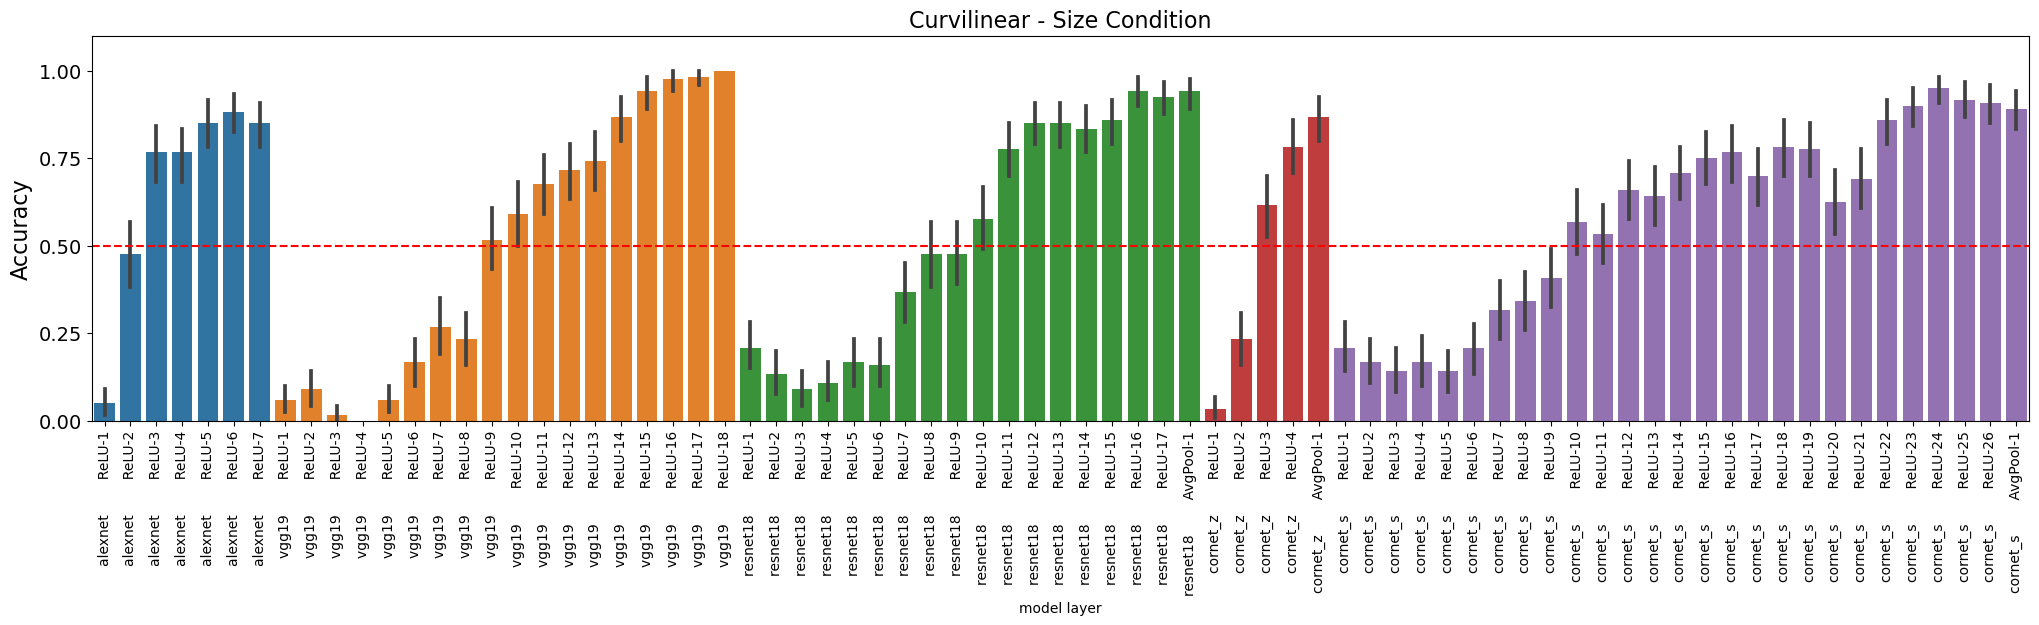

In [6]:
condition = '_rot'
df = pd.read_csv(f'results/Rectilinear_acc{condition}_similarity.csv')
#convert AdapativeAvgPool2d to AvgPool
df['layer'] = df['layer'].apply(lambda x: x.replace('AdaptiveAvgPool2d', 'AvgPool'))
plot_all_models(df, 'Rectilinear - Orientation Condition',f'_{condition}_similarity')

df = pd.read_csv(f'results/Curvilinear_acc{condition}_similarity.csv')
#convert AdapativeAvgPool2d to AvgPool
df['layer'] = df['layer'].apply(lambda x: x.replace('AdaptiveAvgPool2d', 'AvgPool'))
plot_all_models(df, 'Curvilinear - Orientation Condition',f'_{condition}_similarity')


condition = '_scale'
df = pd.read_csv(f'results/Rectilinear_acc{condition}_similarity.csv')
#convert AdapativeAvgPool2d to AvgPool
df['layer'] = df['layer'].apply(lambda x: x.replace('AdaptiveAvgPool2d', 'AvgPool'))
plot_all_models(df, 'Rectilinear - Size Condition',f'_{condition}_similarity')

df = pd.read_csv(f'results/Curvilinear_acc{condition}_similarity.csv')
#convert AdapativeAvgPool2d to AvgPool
df['layer'] = df['layer'].apply(lambda x: x.replace('AdaptiveAvgPool2d', 'AvgPool'))
plot_all_models(df, 'Curvilinear - Size Condition',f'_{condition}_similarity')
